## Assignment 4 - EEG
### Biosensory Computing - Fall 2023
#### Erin Jones - 10/23/2023

#### Question 0

I am comfortable with any/all of my work being shared with the class

#### Question 1

* Which recording was made with the person's eyes open?
* Which two recordings are from the same person performing the same task?
* Which recording belongs to a different person?
* What is the ratio between the total signal power of recording 1 and of recording 2?

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.integrate import simps
from scipy.stats import pearsonr
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

In [3]:
s1_df = (pd.read_csv('./a4_data/record1.csv', header=None, encoding='utf-8'))
s2_df = (pd.read_csv('./a4_data/record2.csv', header=None, encoding='utf-8'))
s3_df = (pd.read_csv('./a4_data/record3.csv', header=None, encoding='utf-8'))
s4_df = (pd.read_csv('./a4_data/record4.csv', header=None, encoding='utf-8'))

fs = 512 # sampling fq in Hz
epoch_len = len(s1_df.columns) # double check to make sure all the df lengths match before assuming this
time = (np.arange(epoch_len)/fs)

# form matrix containing all participants
eeg_all_participants = np.empty(shape=(4,epoch_len))
eeg_all_participants[0] = np.asarray(s1_df)
eeg_all_participants[1] = np.asarray(s2_df)
eeg_all_participants[2] = np.asarray(s3_df)
eeg_all_participants[3] = np.asarray(s4_df)

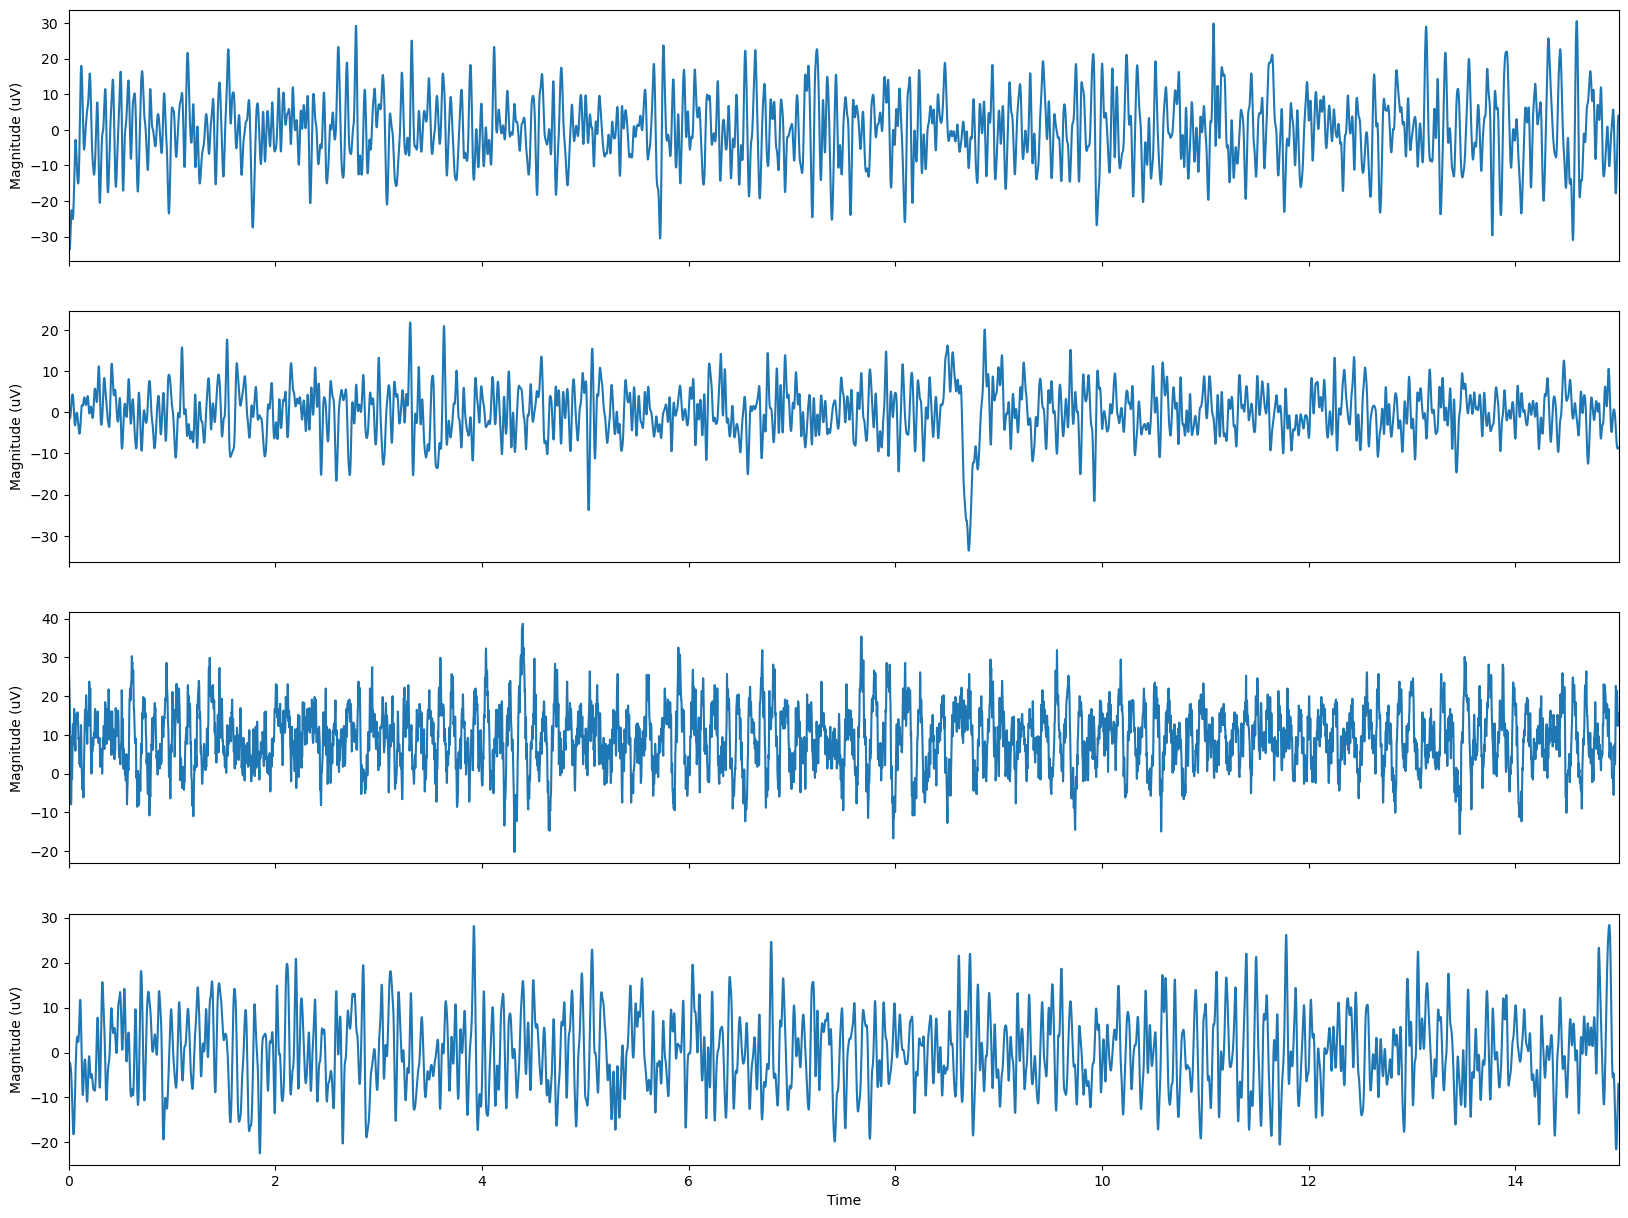

In [6]:
# plot of EEG signal for each participant separately

indices = [0, 1, 2, 3]
fig, axs = plt.subplots(4, sharex=True, figsize=(20,15))

for i in indices:
    axs[i].plot(time, eeg_all_participants[i])
    axs[i].set_ylabel('Magnitude (uV)')

axs[indices[-1]].set_xlabel('Time')
axs[indices[-1]].set_xlim(0,15)
plt.show()

#### Power Spectral Density

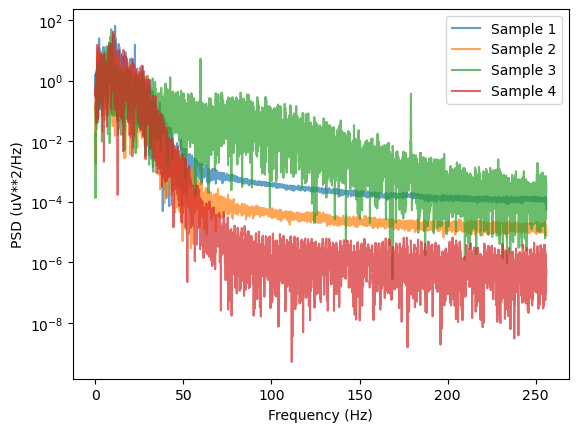

In [22]:
# Compute and plot Power Spectral Density (PSD) for resting state and math task

psd_width = int(epoch_len/2) + 1
psd = np.empty(shape=(4,psd_width))

for sample in range(0,4):
    f, psd[sample] = signal.periodogram(eeg_all_participants[sample], fs) 

fig, axs = plt.subplots()
for sample in range(0,4):
    axs.semilogy(f[1:], psd[sample][1:],label=f"Sample {sample + 1}", alpha=0.7)

axs.set_xlabel('Frequency (Hz)')
axs.set_ylabel('PSD (uV**2/Hz)')
axs.legend(loc=1)
plt.show()

#### PSD Using Welch's Method

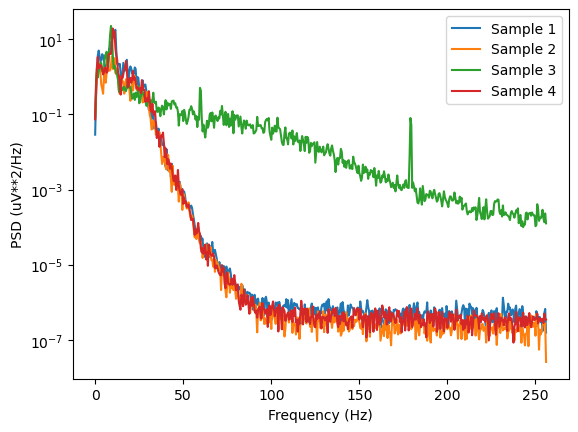

In [21]:
wws = 2 # welch window size in seconds
psdw_width = int(wws*fs/2) + 1
psdw = np.empty(shape=(4,psdw_width))

for sample in range(0,4):
    fw, psdw[sample] = signal.welch(eeg_all_participants[sample], fs, nperseg=wws*fs, average='median')

fig, axs = plt.subplots()
for sample in range(0,4):
    axs.semilogy(fw[:], psdw[sample],label=f"Sample {sample + 1}")

axs.set_xlabel('Frequency (Hz)')
axs.set_ylabel('PSD (uV**2/Hz)')
axs.legend(loc=1)
plt.show()

The above chart makes it pretty clear that the 3rd sample/individual is not like the others. My guess would be that Individual 3 is the odd person out.

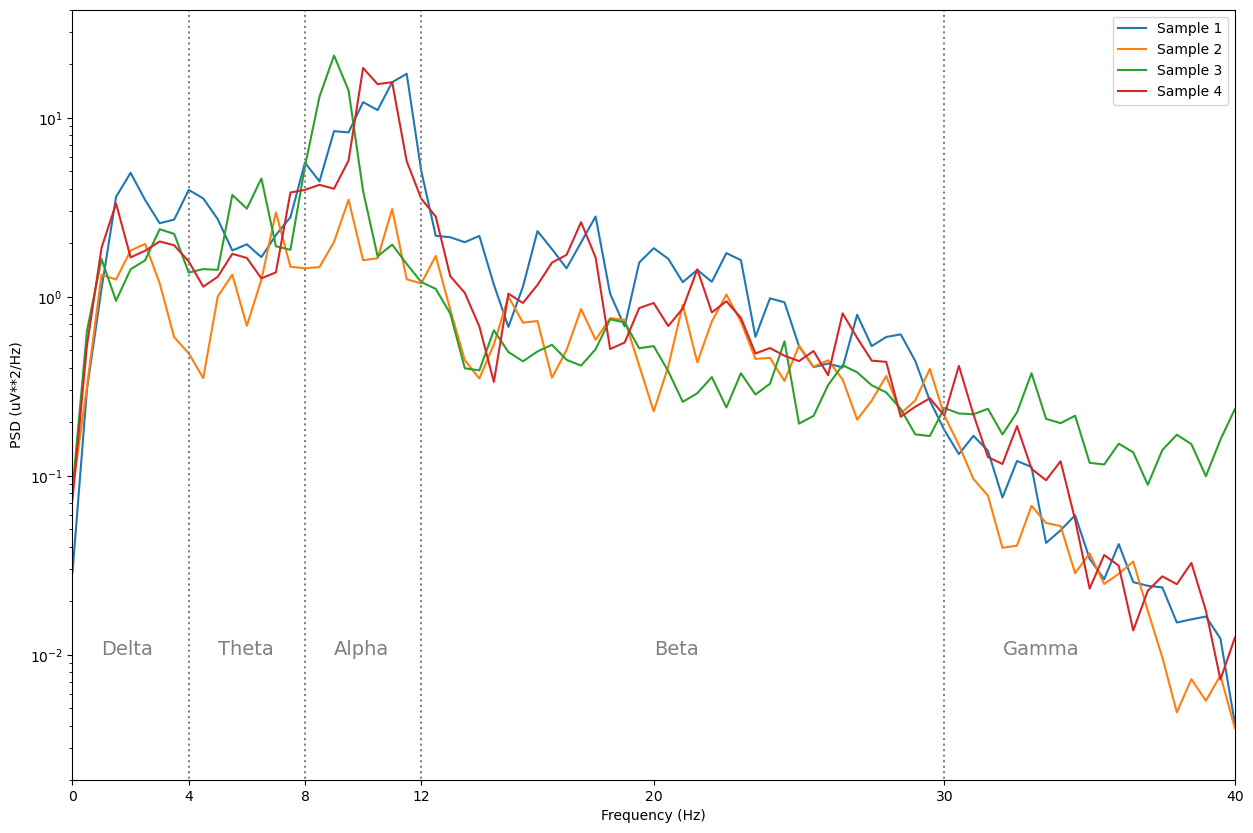

In [25]:
# Zoom in to 0-40Hz range

xtickslist_f = [0,4,8,12,20,30,40]

fig, axs = plt.subplots(figsize=(15,10))

for sample in range(0,4):
    axs.semilogy(fw[:], psdw[sample],label=f"Sample {sample + 1}")

axs.set_xlabel('Frequency (Hz)')
axs.set_ylabel('PSD (uV**2/Hz)')
xmax = 40; ymax = 40; ymin = 0.002
axs.set_xlim(0,xmax)
axs.set_ylim(ymin,ymax)
axs.set_xticks(xtickslist_f)
axs.legend(loc=1)

axs.vlines(4,0,ymax,color='grey',linestyle='dotted')
axs.vlines(8,0,ymax,color='grey',linestyle='dotted')
axs.vlines(12,0,ymax,color='grey',linestyle='dotted')
axs.vlines(30,0,ymax,color='grey',linestyle='dotted')
axs.text(1, 0.01, 'Delta', size=14, color='grey')
axs.text(5, 0.01, 'Theta', size=14, color='grey')
axs.text(9, 0.01, 'Alpha', size=14, color='grey')
axs.text(20, 0.01, 'Beta', size=14, color='grey')
axs.text(32, 0.01, 'Gamma', size=14, color='grey')
plt.show()

Calculating Pearson's R

In [29]:
def calc_pr(psdw_matrix, sample_a, sample_b):
    print(f'\nPearsons correlation between {sample_a+1} and {sample_b+1} (0.5-40Hz range): %.3f' % pearsonr(psdw_matrix[sample_a][1:80],psdw_matrix[sample_b][1:80])[0])
    print(f'Pearsons correlation between {sample_a+1} and {sample_b+1} (8-12Hz range): %.3f' % pearsonr(psdw_matrix[0][16:24],psdw_matrix[sample_b][16:24])[0])
    print(f'Pearsons correlation between {sample_a+1} and {sample_b+1} (30-40Hz range): %.3f' % pearsonr(psdw_matrix[0][60:80],psdw_matrix[sample_b][60:80])[0])


calc_pr(psdw, 0, 1)
calc_pr(psdw, 0, 2)
calc_pr(psdw, 0, 3)
calc_pr(psdw, 1, 2)
calc_pr(psdw, 1, 3)
calc_pr(psdw, 2, 3)


Pearsons correlation between 1 and 2 (0.5-40Hz range): 0.682
Pearsons correlation between 1 and 2 (8-12Hz range): 0.081
Pearsons correlation between 1 and 2 (30-40Hz range): 0.847

Pearsons correlation between 1 and 3 (0.5-40Hz range): 0.433
Pearsons correlation between 1 and 3 (8-12Hz range): -0.601
Pearsons correlation between 1 and 3 (30-40Hz range): 0.697

Pearsons correlation between 1 and 4 (0.5-40Hz range): 0.844
Pearsons correlation between 1 and 4 (8-12Hz range): 0.508
Pearsons correlation between 1 and 4 (30-40Hz range): 0.814

Pearsons correlation between 2 and 3 (0.5-40Hz range): 0.568
Pearsons correlation between 2 and 3 (8-12Hz range): -0.601
Pearsons correlation between 2 and 3 (30-40Hz range): 0.697

Pearsons correlation between 2 and 4 (0.5-40Hz range): 0.615
Pearsons correlation between 2 and 4 (8-12Hz range): 0.508
Pearsons correlation between 2 and 4 (30-40Hz range): 0.814

Pearsons correlation between 3 and 4 (0.5-40Hz range): 0.313
Pearsons correlation between 3 

Again, the lowest correlation appears between sample 3 and the other individuals. I am fairly certain that sample 3 is the odd person out. Dr. Chuang's long-term study [1] found that the Gamma range is particularly steady over time, leading me to focus particularly on the 30-40Hz range. It seems that it is the same across the board *except* when comparing 1 and 3 and 2 and 3. Again, this singles out the third individual except when compared with the 4th sample in the gamma range.

Looking at the alpha peaks in the alpha range, per Dr. Chuang's study, we expect to see a lower peak for the eyes open samples due to alpha attenuation [1]. This singles out sample two as being of interest for being the eyes open task.

By process of elimination, this leaves samples one and four as those being completed by the same person, likely performing the same task. This makes sense, as we see a spectral footprint that is similar marked by the highest Pearson's correlation when comparing the two.

In [26]:
# Analyze band powers

def calc_print_band_pow(psdw_matrix, sample_n):
    i = sample_n
    p_total = simps(psdw_matrix[i])
    p_d = simps(psdw_matrix[i][1:9])/p_total*100 # 0.5-4 Hz
    p_t = simps(psdw_matrix[i][8:17])/p_total*100 # 4-8 Hz
    p_a = simps(psdw_matrix[i][16:25])/p_total*100 # 8-12 Hz
    p_b = simps(psdw_matrix[i][24:61])/p_total*100 # 12-30 Hz
    p_g = simps(psdw_matrix[i][60:400])/p_total*100 # 30-200 Hz

    print(f'\nSample {i+1}:')
    print('Absolute total power: %.3f uV^2' % p_total)
    print('Relative delta power: %.1f percent' % p_d)
    print('Relative theta power: %.1f percent' % p_t)
    print('Relative alpha power: %.1f percent' % p_a)
    print('Relative beta power: %.1f percent' % p_b)
    print('Relative gamma power: %.1f percent' % p_g)


for sample in range(0,4):
    calc_print_band_pow(psdw, sample)


Sample 1:
Absolute total power: 170.125 uV^2
Relative delta power: 12.0 percent
Relative theta power: 12.2 percent
Relative alpha power: 48.6 percent
Relative beta power: 26.4 percent
Relative gamma power: 0.8 percent

Sample 2:
Absolute total power: 55.041 uV^2
Relative delta power: 15.8 percent
Relative theta power: 17.4 percent
Relative alpha power: 28.6 percent
Relative beta power: 36.7 percent
Relative gamma power: 1.7 percent

Sample 3:
Absolute total power: 126.942 uV^2
Relative delta power: 9.2 percent
Relative theta power: 17.2 percent
Relative alpha power: 48.4 percent
Relative beta power: 12.4 percent
Relative gamma power: 13.1 percent

Sample 4:
Absolute total power: 134.229 uV^2
Relative delta power: 10.0 percent
Relative theta power: 11.4 percent
Relative alpha power: 51.9 percent
Relative beta power: 24.6 percent
Relative gamma power: 1.4 percent


The above clearly shows the alpha attenuation mentioned above in Sample 2 with the lowest amount of relative alpha power across the samples - this is record of task with the eyes open. Interestingly, Sample 3 also departs from the pack when looking at the relative gamma power, which is a much higher percentage than the other samples, reconfirming that this is likely the odd person out. The distribution between samples one and four is quite similar, which is to be expected from the same person doing the same task.

In [31]:
ratio_1_2 = simps(psdw[0])/simps(psdw[1])
print("The ratio of total power between recording one and recording two is %.3f" % ratio_1_2) 

The ratio of total power between recording one and recording two is 3.091


### Question 1 Answer Summary

* Sample 2 was made with eyes open as marked by the alpha attenuation seen in both the power band analysis and visual inspection of the graph in the 0-40Hz range, focusing on the alpha band
* Samples 1 & 4 are likely recordings of the same person performing the same task. The distribution of power in the 0-40Hz range is most similar and the Pearson's correlation between the two is the highest across the group
* Sample 3 likely belongs to a different person based on visual inspection of the PSD chart using Welch's method and the low level of correlation with other recordings, specifically in the gamma range.
* The ratio of absolute total power between recordings one and two is 3.091

### Question 2

<b> What are the main arguments made by ATM? What are the main defenses put forth by WK in their response? Which position are you more sympathetic toward? Why? What is your take on the responsibilities and ethics of researchers undertaking and publishing this type of research?</b> 

The first half of ATM's paper is populated by findings from a mechanical turk study that they ran attempting to tease out some of the choices/preferences individuals may have that impact the way their face appears in pictures (e.g. wearing makeup or glasses) [2]. The purpose behind this is to disprove WK's assertion that facial differences largely stem from differences in prenatal hormone exposure. WK does not really respond to this argument in the response, only briefly pointing back to the paper stating "As we discuss in our paper, gay and straight faces do differ in terms of grooming." [3] I feel that this argument is well made by ATM and it successfully discredits the problematic assertion that the WK study proves gay/straight faces have physical differences in jaw size, nose placement etc. However, I also believe that it stands to prove one of the main purposes behind the paper correct to some degree. 

ATM's research on mechanical turk proves that there are behavioral correlates with sexual orientation that may impact the way that a persons face looks in a photograph. An algorithm deployed by a malicious entity attempting to identify and persecute members of the LGBTQIA+ community is not going to care *why* those differences are identifiable via photograph, but rather that they do exist and that an algorithm can be trained to spot them. This rockets us to the final point made in the ATM article, which is something like 'There are so many more important things to be using facial recognition technology to research and prove, and you chose this!?' While this argument is not as precisely laid out in the ATM article, I believe it to be incredibly piercing, as I feel that WK does not adequately address the concern that this research may offer a perverse incentive to governments in Russia or Saudi Arabia to deploy a system like this, despite the accuracy not being perfect. In fact WK's work offers these governments an avenue to say "A Stanford professor and published paper proves that gay faces are 'gender-atypical' and can be singled out accurately using off-the-shelf facial recognition technology." WK defends themselves by stating that they published, because this use-case would have been implemented with or without their research and their goal is to alert the gay community and policy makers to this privacy concern. I feel that both of these defenses were relatively weak. The first defense downplays WK's influence based on their institution and the reputation of the journal and Stanford's review board. They are not just doing something that could have been done anyway - their status at an elite institution breathes immense amounts of credibility into their findings. Furthermore, it isn't just like they did some research and published an objective paper about the findings. They placed their findings in the framework of physiognomic findings. They crafted a narrative that downplayed the impact of 'transient facial features' and uplifted the prenatal hormone theory [4]. Even the title 'Deep Neural Networks Are More Accurate Than Humans at Detecting Sexual Orientation from Facial Images,' screams that their positioning is non-neutral from the rooftops. As to the second defense, that the interest of the researchers is privacy, the article does very little to suggest what the gay community might do to obfuscate in the face of such an algorithm. Considering how concerning these findings are, I feel it is within the realm of their responsibility to offer a solution if that was the true purpose of their research as they defended it to be.

The strongest argument made by ATM occurs at the end of their article, when they discuss the impacts of photo angles on apparent size and proportion of facial features in a 2D image. This argument is again posited with the intention of destroying WK's assertion regarding true physical facial features that correlate with sexual orientation. WK does not acknowledge this argument at all in the defense and I think this is farily telling in terms of the strength of this argument. While WK does acknowledge positioning of the head in Figure B of the paper on page 11 [4], in their response, they basically state that they felt they did a 'pretty good job' with accounting for these confounding variables, without any grounds for their assertion. ATM's article even cites work indicating it is incredibly difficult to control for this confound, which casts a significant amount of doubt on bias that exists in their training datasets. Not only did WK collect their training data from dating websites where people are likely to emote their sexual preference in photos, but they tested it on just standard social media, claimed the results were the same and *assumed* their problems were solved. I would argue that any photos on social media (dating webiste or not) are going to bear the mark of social decisions geared towards making a person 'attractive' to their intended audience. There are deeply rooted biological motives for this behavior, too large to unpack in a single assignment response, but scraping photos from social media is very unlikely to produce an unbiased photo set. That said, I wish to return to my earlier point that the grounds on which WK claims physiological differences exist between facial features of gay and straight individuals are shaky, BUT that does not prevent a government from using this algorithm to comb through any social media and assess the straightness of an individual. The concern regarding privacy posed by WK is still very real and should not be discredited. 

This brings me to my final point, regarding the responsibilities and ethics of researchers understaking and publishing this type of research. I already expressed frustration with the fact that WK did not publish any real solution to the problem they have identified. I feel that it is the duty of researchers, especially those at renowned institutions publishing in highly regarded journals, to offer a path forward. There should have been an entire section dedicated to suggested policies and ways that the gay community can shield themselves from identification. In a battle that is truly life or death for some individuals, publishing research like this is as bad as yelling 'you're exposed' on the battle field, but not offering any cover. At least prior to publication, the information was theoretically 'unknown' by adversaries, but now it is out in the open. I think evidence of coordinating with the potentially endangered community and policy makers prior to publication should be a requirement for publication of this type of research. I also believe that a datasheet and dataset should have been published to allow other researchers greater visibility into the data informing these results. This publication allows for a checks and balances to occur, as it is often extremely difficult to identify every single bias or issue with a dataset prior to publication. By publishing the dataset, you are then publishing in the spirit of collaboration with hopes that others will participate, instead of publishing "facts" (as done by WK) and hoping the world simply trusts your work.

References

[1] Chuang J. Neural Dynamics of a Single Human with Long-Term, High Temporal Density Electroencephalography. Annu Int Conf IEEE Eng Med Biol Soc. 2021 Nov;2021:7199-7205. doi: 10.1109/EMBC46164.2021.9630280. PMID: 34892761.

[2] Aguera y Arcas, B., Mitchell, M., &; Todorov, A. (2018, January 11). Do algorithms reveal sexual orientation or just expose our stereotypes? Medium. Retrieved 2023, from https://medium.com/@blaisea/do-algorithms-reveal-sexual-orientation-or-just-expose-our-stereotypes-d998fafdf477. 

[3] https://docs.google.com/document/d/11oGZ1Ke3wK9E3BtOFfGfUQuuaSMR8AO2WfWH3aVke6U/edit#

[4] Wang, Y. & Kosinski, M. “Deep Neural Networks Are More Accurate Than Humans at Detecting Sexual Orientation from Facial Images.” PsyArXiv, 7 Sept. 2017. Web.
